### Machine Learning Engineer Nanodegree Capstone Project
#### Michael Seybold, 1/7/2018

#### For the most part this notebook contains code to process and run models for the smog test project.  Some summary statistics and a few visualizations are also generated.

In [1]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from numpy.random import seed
seed(1)

import pickle
import re

%precision %.2f

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from keras.layers import Dense, Flatten, Dropout, Activation
from keras.models import Sequential, load_model
from keras import regularizers
import keras

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Reading and aggregating data from the first 9 months of 2016 as a training set

In [3]:
def get_file_name(month, year = '2016'):
    file_str = 'ois_test_' + year
    if month < 10:
        file_str2 = file_str + '0' + str(month) + '.csv'
    else:
        file_str2 = file_str + str(month) + '.csv'
    return file_str2

In [4]:
cols = ['VEHICLESYSTEMNUMBER', 'VEHICLEMAKE', 'VEHICLEMODELYEAR', 'INSPECTIONREASON', 'ODOMETERREADING',
        'TESTSTARTDTTIME', 'TESTMONTH', 'TESTYEAR', 'OVERALLTESTRESULT']

In [5]:
bar = pd.DataFrame()
for i in range(1,10):
    bar_2016 = pd.read_csv(get_file_name(i), usecols = cols)
    bar = pd.concat([bar_2016, bar])

### Reading 1 month of test data from Jan. 2017

In [7]:
bar_eval2 = pd.read_csv('ois_test_201701.csv', usecols = cols)

### Main processing function, limits data to biennial inspections, filters the data and drops unnecessary fields

In [8]:
def process(bar):
    
    bar_filter = bar.copy()

    reason = ['B', 'P', 'S', 'D']
    bar_filter = bar_filter.loc[bar['INSPECTIONREASON'].isin(reason)]
    total = len(bar_filter)

    bar_filter['vehicle_age'] = ((bar_filter.TESTYEAR) + 1) - bar_filter['VEHICLEMODELYEAR']
    bar_filter['high_emitter'] = bar_filter['INSPECTIONREASON'].apply(lambda x: 1 if x == 'P' else 0)
    bar_filter['pass_fail'] = bar_filter['OVERALLTESTRESULT'].apply(lambda x: 0 if x == "P" else 1)

    bar_filter = bar_filter[(bar_filter['VEHICLEMODELYEAR'] > 1999)  & (bar_filter['ODOMETERREADING'] > 0) &
                      (bar_filter['vehicle_age'] > 8) & (bar_filter['ODOMETERREADING'] < 500000)] # & (bar_filter['ODOMETERREADING'] < 500000)

    bar_filter = bar_filter.drop_duplicates(subset = ['VEHICLESYSTEMNUMBER'], keep = 'first')

    bar_filter.dropna(inplace = True)

    bar_filter.drop(['TESTSTARTDTTIME', 'TESTYEAR', 'TESTMONTH', 'OVERALLTESTRESULT', 'VEHICLEMODELYEAR',
                   'INSPECTIONREASON', 'VEHICLESYSTEMNUMBER', 'ODOMETERREADING'], axis = 1, inplace = True)
       
    return bar_filter.copy(), total

In [9]:
bar_final, total_final = process(bar)
test_fraction = 0.2
total_final *= test_fraction
bar_final_eval1, total_final_eval1 = process(bar_eval1)
bar_final_eval2,total_final_eval2 = process(bar_eval2)

### Identifies makes in the dataset that have at least 500 vehicles tested, and filters the data accordingly

In [10]:
makes = bar_final.VEHICLEMAKE.value_counts()
makes = set(makes[makes > 500].index)
print(makes)
mans = makes.intersection(bar_final_eval1.VEHICLEMAKE.unique()).intersection(bar_final_eval2.VEHICLEMAKE.unique())
len(mans)

{'SAAB', 'MINI', 'SMART', 'ISUZU', 'DCX SPRINTER', 'BMW', 'AUDI', 'HYUNDAI', 'DAEWOO', 'CHRYSLER', 'OLDSMOBILE', 'PORSCHE', 'MASERATI', 'LINCOLN', 'ACURA', 'HONDA', 'LAND ROVER', 'NISSAN', 'MITSUBISHI', 'MAZDA', 'INFINITI', 'JAGUAR', 'KIA', 'SUBARU', 'DODGE', 'BENTLEY', 'PLYMOUTH', 'JEEP', 'VOLKSWAGEN', 'TOYOTA', 'FERRARI', 'SATURN', 'GMC', 'CADILLAC', 'MERCEDES-BENZ', 'CHEVROLET', 'VOLVO', 'SUZUKI', 'BUICK', 'FORD', 'PONTIAC', 'MERCURY', 'LEXUS', 'HUMMER'}


43

In [11]:
bar_final = bar_final[bar_final.VEHICLEMAKE.isin(mans)].reset_index(drop = True)
bar_final_eval1 = bar_final_eval1[bar_final_eval1.VEHICLEMAKE.isin(mans)].reset_index(drop = True)
bar_final_eval2 = bar_final_eval2[bar_final_eval2.VEHICLEMAKE.isin(mans)].reset_index(drop = True)

#### Various stats and summary info

In [21]:
bar_final.corr()

vehicle_age  high_emitter  pass_fail
vehicle_age          1.00          0.53       0.11
high_emitter         0.53          1.00       0.09
pass_fail            0.11          0.09       1.00

In [12]:
bar_final_eval2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439577 entries, 0 to 439576
Data columns (total 4 columns):
VEHICLEMAKE     439577 non-null object
vehicle_age     439577 non-null int64
high_emitter    439577 non-null int64
pass_fail       439577 non-null int64
dtypes: int64(3), object(1)
memory usage: 13.4+ MB


In [13]:
bar_final.groupby(['vehicle_age'])['pass_fail'].value_counts(normalize = True) * 100

vehicle_age  pass_fail
9            0           96.82
             1            3.18
10           0           95.63
             1            4.37
11           0           95.48
             1            4.52
12           0           93.27
             1            6.73
13           0           94.06
             1            5.94
14           0           90.86
             1            9.14
15           0           91.61
             1            8.39
16           0           87.84
             1           12.16
17           0           88.59
             1           11.41
Name: pass_fail, dtype: float64

In [46]:
bar_final.loc[:, 'pass_fail'].value_counts(normalize = True)*100

0   93.14
1    6.86
Name: pass_fail, dtype: float64

#### The following functions prepare train and test data, normalize the age feature, add a polynomial to age and process the categorical vehicle "make" feature with get_dummies so that it is represented in binary format

In [12]:
def poly(data):
    
    X = data.copy()
    X_poly = X.drop(['high_emitter', 'VEHICLEMAKE'], axis = 1)
    poly = PolynomialFeatures(2, include_bias= True)
    X_poly = poly.fit_transform(X_poly)
    X_poly = X_poly.astype(np.float32)
    X_poly = pd.DataFrame(X_poly)
    X_poly['make'] = X['VEHICLEMAKE']
    X_poly['emitter'] = X['high_emitter'].astype(np.float32)
    
    return X_poly

In [13]:
def split(bar_final, test_size):

    y = bar_final['pass_fail']
    X = bar_final.drop('pass_fail', axis = 1)
    
    scalar = StandardScaler()

    X['vehicle_age'] = scalar.fit_transform(X['vehicle_age'].values.reshape(-1,1))

    X = poly(X)
    X = pd.get_dummies(X)
    
    sample = []
    train_test = (train_test_split(X, y, test_size = test_size))
    y_train2 = keras.utils.to_categorical(train_test[2], 2)
    y_test2 = keras.utils.to_categorical(train_test[3], 2)
    sample.extend((train_test, y_train2, y_test2))
    
    return sample

#### Calls the above functions to split the 9 month dataset into train and validation sets, and processes a 1 month Jan 2017 test set

In [14]:
sample = split(bar_final, test_fraction)

X_train, X_test, y_train, y_test = sample[0]
y_train2 = sample[1]
y_test2 = sample[2]

C:\Users\mcbold\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
sample_eval2 = split(bar_final_eval2, 0.99)

X_train_eval2, X_test_eval2, y_train_eval2, y_test_eval2 = sample_eval2[0]
y_train2_eval2 = sample_eval2[1]
y_eval2_eval2 = sample_eval2[2]

C:\Users\mcbold\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### Invokes imblearn's RandomUnderSampler and Smote

In [21]:
nm1 = RandomUnderSampler(random_state=0)
X_res, y_res = nm1.fit_sample(X_train, y_train)
y_res2 = keras.utils.to_categorical(y_res, 2)

In [19]:
X_smote, y_smote = SMOTE().fit_sample(X_train, y_train)


In [20]:
y_smote2 = keras.utils.to_categorical(y_smote, 2)

### Functions for generating and fitting classifiers, and for scoring

In [25]:
def scoring(model, X_test, y_test, total, keras_flag = 0):

    preds = model.predict(X_test)
    
    if keras_flag == 0:
        score = model.score(X_test, y_test)
        probs = model.predict_proba(X_test)
        print('accuracy: ', round(score,2))
    else:
        preds = preds[:,1] > 0.5

    print('')
    conf = confusion_matrix(y_test, preds)
    print(conf)
    print('')
    print('classification report')
    print(classification_report(y_test, preds)) #target_names=target_names
    print('negative predictive ratio:', round(conf[0,0]/conf[1,0], 2))
    print('false negative rate:', round(conf[1,0]/(conf[1,0] + conf[1,1]) * 100, 2), '%')
    print('% of total:', round(conf[0,0]/total*100, 2), '%')
    
    return preds
    

In [18]:
def classifier(weight, clf, X_train, y_train, X_test, y_test, total, y_test2 = None):
    
    keras_flag = 0
    
    if clf == 'rf':
        
        model = RandomForestClassifier(n_estimators = 100, max_depth = 10, min_samples_split = 5,
                                n_jobs = -1, class_weight = weight, random_state = 0)
    elif clf == 'bbc':
        
        model = BalancedBaggingClassifier(ratio = 'auto', replacement=False, random_state=0, n_estimators=100, n_jobs = -1)
        
    elif clf == 'xgb':
        params2 = {
        'objective': 'binary:logistic',
        'max_depth': 2,
        'learning_rate': 0.2,
        'silent': 1.0,
        'n_estimators': 100,
        'n_jobs': 8,
        'scale_pos_weight': weight,
        'random_state': 42
        }
    
        model = XGBClassifier(**params2)
        
    elif clf == 'lr':
        
        model = LogisticRegression(penalty = 'l2', class_weight = weight, random_state = 0)
        
    elif clf == 'keras':
        
        model = Sequential()
        model.add(Dense(32, input_shape = (X_train.shape[1],), activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
        model.add(Dropout(0.2))
        model.add(Dense(2, activation = 'sigmoid'))
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])
        model.fit(X_train, y_train, epochs = 3, class_weight = weight, batch_size = 32)
        score = model.evaluate(X_test, y_test2)
        print('accuracy: ', score[1])
        keras_flag = 1
        
    else:
        print('no model was passed')
        return
    
    if keras_flag == 0:
        model.fit(X_train, y_train)
    
    scoring(model, X_test, y_test, total, keras_flag)
        
    return model

### Training a variety of models on data from the first 9 months of 2016

#### BalancedBaggingClassifier from imbalanced learn package- no weight hyperparameter to tune, just looking at general performance of ensemble 

In [42]:
bar_bbc = classifier(1, 'bbc', X_train, y_train, X_test, y_test, total_final)

accuracy:  0.58

[[440079 325218]
 [ 19067  36758]]

classification report
             precision    recall  f1-score   support

          0       0.96      0.58      0.72    765297
          1       0.10      0.66      0.18     55825

avg / total       0.90      0.58      0.68    821122

negative predictive ratio: 23.08
false negative rate: 34.15 %
% of total: 41.8 %


#### Random Forest imbalanced

In [27]:
weight = {1:22} #{1:22}
bar_rf = classifier(weight, 'rf', X_train, y_train, X_test, y_test, total_final)

accuracy:  0.27

[[168696 596601]
 [  4605  51220]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.22      0.36    765297
          1       0.08      0.92      0.15     55825

avg / total       0.91      0.27      0.34    821122

negative predictive ratio: 36.63
false negative rate: 8.25 %
% of total: 16.03 %


#### Random Forest balanced- still have to tune class weights a little bit

In [32]:
weight_res = {1:1.6} #{1:1.7}
rf_res = classifier(weight_res, 'rf', X_smote, y_smote, X_test, y_test, total_final)

accuracy:  0.26

[[165345 599952]
 [  4429  51396]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.22      0.35    765297
          1       0.08      0.92      0.15     55825

avg / total       0.91      0.26      0.34    821122

negative predictive ratio: 37.33
false negative rate: 7.93 %
% of total: 15.71 %


#### Logistic Regression imbalanced, with several charts that plot probabilities

In [19]:
weight_lr = {1:26} #{1:26.5}
bar_lr = classifier(weight_lr, 'lr', X_train, y_train, X_test, y_test, total_final)

accuracy:  0.26

[[163844 601453]
 [  4563  51262]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.21      0.35    765297
          1       0.08      0.92      0.14     55825

avg / total       0.91      0.26      0.34    821122

negative predictive ratio: 35.91
false negative rate: 8.17 %
% of total: 15.56 %


In [22]:
probs = bar_lr.predict_proba(X_test)

In [51]:
print(np.mean(probs[:,1]))
print(np.median(probs[:,1]))
print(np.std(probs[:,1]))

0.619026234674644
0.6260512528872847
0.1246230113108822


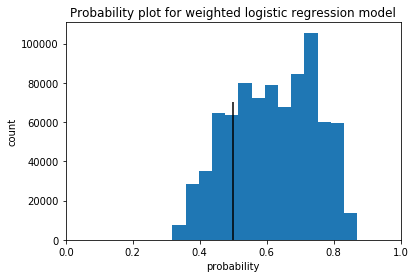

In [56]:
plt.hist(probs[:,1], bins = 15)
plt.title('Probability plot for weighted logistic regression model')
plt.xlabel('probability')
plt.ylabel('count')
plt.xlim(0,1)
plt.vlines(0.5, 0, 70000)

In [52]:
bar_lr_unweighted = classifier({1:1}, 'lr', X_train, y_train, X_test, y_test, total_final)
probs_unweighted = bar_lr_unweighted.predict_proba(X_test)

accuracy:  0.93

[[765297      0]
 [ 55825      0]]

classification report
             precision    recall  f1-score   support

          0       0.93      1.00      0.96    765297
          1       0.00      0.00      0.00     55825

avg / total       0.87      0.93      0.90    821122

negative predictive ratio: 13.71
false negative rate: 100.0 %
% of total: 72.7 %


C:\Users\mcbold\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
print(np.mean(probs_unweighted[:,1]))
print(np.median(probs_unweighted[:,1]))
print(np.std(probs_unweighted[:,1]))

0.06850408917729124
0.060231238704963205
0.03426046876493763


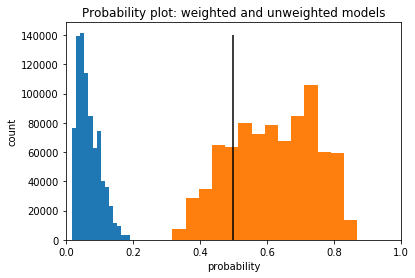

In [70]:
plt.hist(probs_unweighted[:,1], bins = 20)
plt.hist(probs[:,1], bins = 15)
plt.title('Probability plot: weighted and unweighted models')
plt.xlabel('probability')
plt.ylabel('count')
plt.xlim(0., 1.0)
plt.vlines(0.5, 0, 140000)
plt.legend()
plt.show()

In [34]:
max(probs_unweighted[:,1])

0.26

#### Logistic Regression with balanced data

In [44]:
weight_lr_res = {1:2} #{1:2}
lr_res = classifier(weight_lr_res, 'lr', X_smote, y_smote, X_test, y_test, total_final)

accuracy:  0.26

[[158434 606863]
 [  4266  51559]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.21      0.34    765297
          1       0.08      0.92      0.14     55825

avg / total       0.91      0.26      0.33    821122

negative predictive ratio: 37.14
false negative rate: 7.64 %
% of total: 15.05 %


#### XGBoost, imbalanced data

In [45]:
weight_xgb = 24.5 #24.5
bar_xgb = classifier(weight_xgb, 'xgb', X_train, y_train, X_test, y_test, total_final)

C:\Users\mcbold\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\mcbold\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy:  0.28

[[178425 586872]
 [  5105  50720]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.23      0.38    765297
          1       0.08      0.91      0.15     55825

avg / total       0.91      0.28      0.36    821122

negative predictive ratio: 34.95
false negative rate: 9.14 %
% of total: 16.95 %


#### Keras model with imbalanced data

In [24]:
weight_keras = {1:26, 0:1} #{1:19, 0:1}
bar_keras = classifier(weight_keras, 'keras', X_train, y_train2, X_test, y_test, total_final, y_test2)

Epoch 1/3
3284486/3284486 [==============================] - 328s 100us/step - loss: 1.6763 - categorical_accuracy: 0.2306
Epoch 2/3
3284486/3284486 [==============================] - 325s 99us/step - loss: 1.6735 - categorical_accuracy: 0.2303
Epoch 3/3
821122/821122 [==============================] - 41s 50us/step
accuracy:  0.2146745550600276

[[123391 641906]
 [  2942  52883]]

classification report
             precision    recall  f1-score   support

          0       0.98      0.16      0.28    765297
          1       0.08      0.95      0.14     55825

avg / total       0.92      0.21      0.27    821122

negative predictive ratio: 41.94
false negative rate: 5.27 %
% of total: 11.72 %


#### Keras model, balanced data

In [30]:
weight_keras_res = {1:1.8, 0:1} #{1:1.19, 0:1}
keras_res = classifier(weight_keras_res, 'keras', X_smote, y_smote2, X_test, y_test, total_final, y_test2)

Epoch 1/1
821122/821122 [==============================] - 43s 52us/step
accuracy:  0.2391240278545697

[[144080 621217]
 [  3555  52270]]

classification report
             precision    recall  f1-score   support

          0       0.98      0.19      0.32    765297
          1       0.08      0.94      0.14     55825

avg / total       0.91      0.24      0.30    821122

negative predictive ratio: 40.53
false negative rate: 6.37 %
% of total: 13.69 %


### Testing on Jan. 2017 data

In [92]:
print('Random Forest eval2 2017 test results')
rf_eval2 = scoring(bar_rf, X_test_eval2, y_test_eval2, total_final_eval2)
print()
rf_eval2_res = scoring(rf_res, X_test_eval2, y_test_eval2, total_final_eval2)

print()

print('Logistic Regression eval2. 2017 test results')
lr_eval2 = scoring(bar_lr, X_test_eval2, y_test_eval2, total_final_eval2)
print()
lr_eval2_res = scoring(lr_res, X_test_eval2, y_test_eval2, total_final_eval2)

print()

print('XGB eval2. 2017 test results')
print()
xgb_eval2 = scoring(bar_xgb, X_test_eval2, y_test_eval2, total_final_eval2)

print()
print('Keras eval2. 2017 test results')
keras_eval2 = scoring(bar_keras, X_test_eval2, y_test_eval2, total_final_eval2, 1)
print()
keras_eval2_res = scoring(keras_res, X_test_eval2, y_test_eval2, total_final_eval2, 1)

Random Forest eval2 2017 test results
accuracy:  0.24

[[ 63467 329678]
 [  2090  39664]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.16      0.28    393145
          1       0.11      0.95      0.19     41754

avg / total       0.89      0.24      0.27    434899

negative predictive ratio: 30.37
false negative rate: 5.01 %
% of total: 11.4 %

accuracy:  0.24

[[ 62715 330430]
 [  2064  39690]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.16      0.27    393145
          1       0.11      0.95      0.19     41754

avg / total       0.89      0.24      0.27    434899

negative predictive ratio: 30.39
false negative rate: 4.94 %
% of total: 11.26 %

Logistic Regression eval2. 2017 test results
accuracy:  0.28

[[ 81402 311743]
 [  3046  38708]]

classification report
             precision    recall  f1-score   support

          0       0.96      0.21      0.34   

C:\Users\mcbold\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\mcbold\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy:  0.28

[[ 85526 307619]
 [  3340  38414]]

classification report
             precision    recall  f1-score   support

          0       0.96      0.22      0.35    393145
          1       0.11      0.92      0.20     41754

avg / total       0.88      0.28      0.34    434899

negative predictive ratio: 25.61
false negative rate: 8.0 %
% of total: 15.36 %

Keras eval2. 2017 test results

[[ 71640 321505]
 [  2466  39288]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.18      0.31    393145
          1       0.11      0.94      0.20     41754

avg / total       0.88      0.26      0.30    434899

negative predictive ratio: 29.05
false negative rate: 5.91 %
% of total: 12.87 %


[[ 82599 310546]
 [  3087  38667]]

classification report
             precision    recall  f1-score   support

          0       0.96      0.21      0.35    393145
          1       0.11      0.93      0.20     41754

avg / total       0.88

#### Testing on the first 4 months of 2017 data, rolling on a monthly basis

In [94]:
df_list = []
df_months = []
for i in range(1,5):
    test_2017 = pd.DataFrame()
    test_2017 = pd.read_csv(get_file_name(i, '2017'), usecols = ['VEHICLESYSTEMNUMBER', 'VEHICLEMAKE', 'VEHICLEMODELYEAR',
                'INSPECTIONREASON', 'ODOMETERREADING', 'TESTSTARTDTTIME', 'TESTMONTH', 'TESTYEAR', 'OVERALLTESTRESULT'])
    
    test_2017, total_final_test = process(test_2017)
    test_2017 = test_2017[test_2017.VEHICLEMAKE.isin(mans)].reset_index(drop = True)
    
    sample_eval1 = split(test_2017, 0.99)

    X_train_eval1, X_test_eval1, y_train_eval1, y_test_eval1 = sample_eval1[0]
    #y_train2_eval1 = sample_eval1[1]
    #y_test2_eval1 = sample_eval1[2]
    
    print('Month', i, 'results')
    print()
    print('total examples:', total_final_test)
    print()
    lr_eval1 = scoring(bar_lr, X_test_eval1, y_test_eval1, total_final_test)
    
    X_test_eval1['predictions'] = lr_eval1
    X_test_eval1['pass_fail2'] = y_test_eval1

    df_list.append(X_test_eval1[['predictions', 'pass_fail2']])
    df_months.append(test_2017)
    print()
    print('____________________________________________________________')
    print()

C:\Users\mcbold\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Month 1 results

total examples: 556804

accuracy:  0.28

[[ 84709 308403]
 [  3177  38610]]

classification report
             precision    recall  f1-score   support

          0       0.96      0.22      0.35    393112
          1       0.11      0.92      0.20     41787

avg / total       0.88      0.28      0.34    434899

negative predictive ratio: 26.66
false negative rate: 7.6 %
% of total: 15.21 %

____________________________________________________________

Month 2 results

total examples: 572993

accuracy:  0.29

[[ 87927 316110]
 [  3194  39366]]

classification report
             precision    recall  f1-score   support

          0       0.96      0.22      0.36    404037
          1       0.11      0.92      0.20     42560

avg / total       0.88      0.29      0.34    446597

negative predictive ratio: 27.53
false negative rate: 7.5 %
% of total: 15.35 %

____________________________________________________________

Month 3 results

total examples: 681554

accuracy:  

#### Looking at the characteristics of training set vs. the prediction sets, and the test set in general

In [134]:
df_jan_preds = df_list[0]
df_jan = df_months[0]

df_feb_preds = df_list[1]
df_feb = df_months[1]

df_mar_preds = df_list[2]
df_mar = df_months[2]

df_apr_preds = df_list[3]
df_apr = df_months[3]

In [96]:
print(len(df_jan_preds))
print(len(df_jan))

434899
439291


In [97]:
df_jan.head()

VEHICLEMAKE  vehicle_age  high_emitter  pass_fail
0            BMW           11             0          0
1  MERCEDES-BENZ           13             0          0
2          HONDA           12             1          0
3         TOYOTA            9             0          0
4       INFINITI           11             0          0

In [135]:
df_j = df_jan.merge(df_jan_preds, left_index= True, right_index= True)
df_f = df_feb.merge(df_feb_preds, left_index= True, right_index= True)
df_m = df_mar.merge(df_mar_preds, left_index= True, right_index= True)
df_a = df_apr.merge(df_apr_preds, left_index= True, right_index= True)

In [136]:
df_j.head()

VEHICLEMAKE  vehicle_age  high_emitter  pass_fail  predictions  \
0            BMW           11             0          0            1   
1  MERCEDES-BENZ           13             0          0            1   
2          HONDA           12             1          0            1   
3         TOYOTA            9             0          0            0   
4       INFINITI           11             0          0            0   

   pass_fail2  
0           0  
1           0  
2           0  
3           0  
4           0

In [137]:
sum(df_j['pass_fail'])


41787

In [138]:
tn = df_j.loc[(df_j['pass_fail'] == 0) & (df_j['predictions'] == 0)]
fn = df_j.loc[(df_j['pass_fail'] == 1) & (df_j['predictions'] == 0)]
tp = df_j.loc[(df_j['pass_fail'] == 1) & (df_j['predictions'] == 1)]
fp = df_j.loc[(df_j['pass_fail'] == 0) & (df_j['predictions'] == 1)]
predict_neg = df_j.loc[(df_j['predictions'] == 0)]
predict_pos = df_j.loc[(df_j['predictions'] == 1)]
neg = df_j.loc[(df_j['pass_fail'] == 0)]
pos = df_j.loc[(df_j['pass_fail'] == 1)]

In [139]:
df_j.describe()

vehicle_age  high_emitter  pass_fail  predictions  pass_fail2
count   434,899.00    434,899.00 434,899.00   434,899.00  434,899.00
mean         13.43          0.39       0.10         0.80        0.10
std           2.70          0.49       0.29         0.40        0.29
min           9.00          0.00       0.00         0.00        0.00
25%          11.00          0.00       0.00         1.00        0.00
50%          13.00          0.00       0.00         1.00        0.00
75%          16.00          1.00       0.00         1.00        0.00
max          18.00          1.00       1.00         1.00        1.00

In [185]:
predict_pos.describe()

vehicle_age  high_emitter  pass_fail  predictions  pass_fail2
count   347,013.00    347,013.00 347,013.00   347,013.00  347,013.00
mean         14.25          0.49       0.11         1.00        0.11
std           2.35          0.50       0.31         0.00        0.31
min           9.00          0.00       0.00         1.00        0.00
25%          13.00          0.00       0.00         1.00        0.00
50%          14.00          0.00       0.00         1.00        0.00
75%          16.00          1.00       0.00         1.00        0.00
max          18.00          1.00       1.00         1.00        1.00

In [189]:
predict_neg.high_emitter.value_counts(normalize = True)*100
predict_neg.describe()

vehicle_age  high_emitter  pass_fail  predictions  pass_fail2
count    87,886.00     87,886.00  87,886.00    87,886.00   87,886.00
mean         10.21          0.00       0.04         0.00        0.04
std           1.12          0.05       0.19         0.00        0.19
min           9.00          0.00       0.00         0.00        0.00
25%           9.00          0.00       0.00         0.00        0.00
50%          10.00          0.00       0.00         0.00        0.00
75%          11.00          0.00       0.00         0.00        0.00
max          14.00          1.00       1.00         0.00        1.00

In [190]:
neg.describe()

vehicle_age  high_emitter  pass_fail  predictions  pass_fail2
count   393,112.00    393,112.00 393,112.00   393,112.00  393,112.00
mean         13.31          0.37       0.00         0.78        0.00
std           2.69          0.48       0.00         0.41        0.00
min           9.00          0.00       0.00         0.00        0.00
25%          11.00          0.00       0.00         1.00        0.00
50%          13.00          0.00       0.00         1.00        0.00
75%          15.00          1.00       0.00         1.00        0.00
max          18.00          1.00       0.00         1.00        0.00

In [191]:
pos.describe()

vehicle_age  high_emitter  pass_fail  predictions  pass_fail2
count    41,787.00     41,787.00  41,787.00    41,787.00   41,787.00
mean         14.60          0.55       1.00         0.92        1.00
std           2.56          0.50       0.00         0.27        0.00
min           9.00          0.00       1.00         0.00        1.00
25%          13.00          0.00       1.00         1.00        1.00
50%          15.00          1.00       1.00         1.00        1.00
75%          17.00          1.00       1.00         1.00        1.00
max          18.00          1.00       1.00         1.00        1.00

In [182]:
bar_final.describe()

vehicle_age  high_emitter    pass_fail
count 4,105,608.00  4,105,608.00 4,105,608.00
mean         12.82          0.35         0.07
std           2.59          0.48         0.25
min           9.00          0.00         0.00
25%          11.00          0.00         0.00
50%          13.00          0.00         0.00
75%          15.00          1.00         0.00
max          17.00          1.00         1.00

In [161]:
df_a.VEHICLEMAKE.value_counts(normalize=True) * 100

TOYOTA          22.35
HONDA           12.49
FORD            11.18
CHEVROLET       10.04
NISSAN           5.99
DODGE            4.22
LEXUS            3.18
GMC              3.02
BMW              2.91
MERCEDES-BENZ    2.73
CHRYSLER         2.05
ACURA            1.92
VOLKSWAGEN       1.85
HYUNDAI          1.57
JEEP             1.54
MAZDA            1.41
INFINITI         1.11
KIA              1.02
MITSUBISHI       1.01
SATURN           0.93
CADILLAC         0.92
SUBARU           0.88
VOLVO            0.75
PONTIAC          0.68
AUDI             0.65
LINCOLN          0.56
BUICK            0.51
MERCURY          0.37
MINI             0.37
PORSCHE          0.35
JAGUAR           0.31
LAND ROVER       0.23
SUZUKI           0.23
HUMMER           0.15
ISUZU            0.13
SAAB             0.13
OLDSMOBILE       0.09
SMART            0.04
PLYMOUTH         0.03
BENTLEY          0.03
FERRARI          0.02
MASERATI         0.02
DAEWOO           0.02
Name: VEHICLEMAKE, dtype: float64

In [146]:
df_a.pass_fail.value_counts(normalize=True)*100
#df.vehicle_age.value_counts(normalize=True)*100

0   90.80
1    9.20
Name: pass_fail, dtype: float64

In [133]:
bar_final.pass_fail.value_counts(normalize = True)*100

0   93.16
1    6.84
Name: pass_fail, dtype: float64

In [176]:
(X_train.columns)

Index([                   0,                    1,                    2,
                  'emitter',         'make_ACURA',          'make_AUDI',
             'make_BENTLEY',           'make_BMW',         'make_BUICK',
            'make_CADILLAC',     'make_CHEVROLET',      'make_CHRYSLER',
              'make_DAEWOO',         'make_DODGE',       'make_FERRARI',
                'make_FORD',           'make_GMC',         'make_HONDA',
              'make_HUMMER',       'make_HYUNDAI',      'make_INFINITI',
               'make_ISUZU',        'make_JAGUAR',          'make_JEEP',
                 'make_KIA',    'make_LAND ROVER',         'make_LEXUS',
             'make_LINCOLN',      'make_MASERATI',         'make_MAZDA',
       'make_MERCEDES-BENZ',       'make_MERCURY',          'make_MINI',
          'make_MITSUBISHI',        'make_NISSAN',    'make_OLDSMOBILE',
            'make_PLYMOUTH',       'make_PONTIAC',       'make_PORSCHE',
                'make_SAAB',        'make_SATURN', 

#### Matching logistic regression coefficients to their respective features

In [184]:
df_coef = pd.DataFrame(bar_lr.coef_[0], columns = ['coef'])
df_coef['feature'] = X_train.columns
df_coef

coef             feature
0   0.34                   0
1   0.38                   1
2  -0.01                   2
3   0.27             emitter
4  -0.43          make_ACURA
5   0.20           make_AUDI
6   0.44        make_BENTLEY
7  -0.03            make_BMW
8  -0.22          make_BUICK
9  -0.03       make_CADILLAC
10 -0.06      make_CHEVROLET
11  0.21       make_CHRYSLER
12  0.22         make_DAEWOO
13  0.09          make_DODGE
14  0.77        make_FERRARI
15 -0.19           make_FORD
16 -0.20            make_GMC
17 -0.46          make_HONDA
18 -0.01         make_HUMMER
19  0.01        make_HYUNDAI
20 -0.33       make_INFINITI
21  0.15          make_ISUZU
22 -0.09         make_JAGUAR
23 -0.12           make_JEEP
24  0.19            make_KIA
25  0.07     make_LAND ROVER
26 -0.85          make_LEXUS
27 -0.19        make_LINCOLN
28  0.94       make_MASERATI
29  0.18          make_MAZDA
30 -0.24  make_MERCEDES-BENZ
31 -0.35        make_MERCURY
32 -0.23           make_MINI
33  0.15     make_MITSUBISHI
34 -0.15         make_NISSAN
35  0.18     make_OLDSMOBILE
36  0.23       make_PLYMOUTH
37  0.30        make_PONTIAC
38 -0.01        make_PORSCHE
39  0.30           make_SAAB
40  0.09         make_SATURN
41  0.03          make_SMART
42 -0.24         make_SUBARU
43  0.31         make_SUZUKI
44 -0.54         make_TOYOTA
45  0.26     make_VOLKSWAGEN
46 -0.01          make_VOLVO

#### Looking at smog test pass rates by vehicle make for train set and test set

In [165]:
bar_final.groupby('VEHICLEMAKE')['pass_fail'].value_counts(normalize = True)*100

VEHICLEMAKE    pass_fail
ACURA          0           95.04
               1            4.96
AUDI           0           90.98
               1            9.02
BENTLEY        0           91.28
               1            8.72
BMW            0           92.09
               1            7.91
BUICK          0           92.67
               1            7.33
CADILLAC       0           92.38
               1            7.62
CHEVROLET      0           91.93
               1            8.07
CHRYSLER       0           90.50
               1            9.50
DAEWOO         0           83.52
               1           16.48
DODGE          0           90.70
               1            9.30
FERRARI        0           85.03
               1           14.97
FORD           0           92.66
               1            7.34
GMC            0           92.86
               1            7.14
HONDA          0           94.93
               1            5.07
HUMMER         0           93.96
               1  

In [192]:
df_j.groupby('VEHICLEMAKE')['pass_fail'].value_counts(normalize = True)*100

VEHICLEMAKE    pass_fail
ACURA          0           92.66
               1            7.34
AUDI           0           86.39
               1           13.61
BENTLEY        0           90.76
               1            9.24
BMW            0           87.68
               1           12.32
BUICK          0           88.75
               1           11.25
CADILLAC       0           88.59
               1           11.41
CHEVROLET      0           88.05
               1           11.95
CHRYSLER       0           87.32
               1           12.68
DAEWOO         0           87.91
               1           12.09
DODGE          0           86.99
               1           13.01
FERRARI        0           79.41
               1           20.59
FORD           0           90.19
               1            9.81
GMC            0           89.58
               1           10.42
HONDA          0           92.58
               1            7.42
HUMMER         0           91.97
               1  

In [164]:
predict_pos['pass_fail'].value_counts(normalize = True)*100

0   88.87
1   11.13
Name: pass_fail, dtype: float64

In [127]:
predict_neg.VEHICLEMAKE.value_counts(normalize=True)*100

TOYOTA          43.28
HONDA           20.93
LEXUS           10.56
FORD             5.77
NISSAN           3.77
ACURA            2.82
CHEVROLET        2.48
MERCEDES-BENZ    2.45
INFINITI         1.87
BMW              1.51
GMC              1.38
SUBARU           0.85
MINI             0.51
JEEP             0.42
MERCURY          0.41
CADILLAC         0.34
BUICK            0.28
LINCOLN          0.28
JAGUAR           0.09
Name: VEHICLEMAKE, dtype: float64

In [128]:
predict_pos.VEHICLEMAKE.value_counts(normalize=True)*100

TOYOTA          15.69
FORD            12.18
CHEVROLET       12.12
HONDA            9.95
NISSAN           7.02
DODGE            5.19
GMC              3.42
BMW              3.42
MERCEDES-BENZ    2.97
CHRYSLER         2.52
VOLKSWAGEN       2.22
JEEP             1.98
HYUNDAI          1.92
MAZDA            1.91
ACURA            1.76
LEXUS            1.61
MITSUBISHI       1.41
KIA              1.24
SATURN           1.20
CADILLAC         1.16
INFINITI         1.03
VOLVO            0.98
SUBARU           0.93
PONTIAC          0.93
AUDI             0.81
LINCOLN          0.71
BUICK            0.70
MERCURY          0.45
PORSCHE          0.45
LAND ROVER       0.35
JAGUAR           0.35
MINI             0.31
SUZUKI           0.26
HUMMER           0.20
SAAB             0.16
ISUZU            0.13
OLDSMOBILE       0.13
SMART            0.07
PLYMOUTH         0.05
BENTLEY          0.03
DAEWOO           0.03
FERRARI          0.02
MASERATI         0.02
Name: VEHICLEMAKE, dtype: float64

In [143]:
sum(df_j.high_emitter)/len(df)

0.39

In [111]:
tn.describe()

vehicle_age  high_emitter  pass_fail  predictions  pass_fail2
count    84,709.00     84,709.00  84,709.00    84,709.00   84,709.00
mean         10.21          0.00       0.00         0.00        0.00
std           1.12          0.05       0.00         0.00        0.00
min           9.00          0.00       0.00         0.00        0.00
25%           9.00          0.00       0.00         0.00        0.00
50%          10.00          0.00       0.00         0.00        0.00
75%          11.00          0.00       0.00         0.00        0.00
max          14.00          1.00       0.00         0.00        0.00

In [112]:
fn.describe()

vehicle_age  high_emitter  pass_fail  predictions  pass_fail2
count     3,177.00      3,177.00   3,177.00     3,177.00    3,177.00
mean         10.26          0.00       1.00         0.00        1.00
std           1.16          0.06       0.00         0.00        0.00
min           9.00          0.00       1.00         0.00        1.00
25%           9.00          0.00       1.00         0.00        1.00
50%          10.00          0.00       1.00         0.00        1.00
75%          11.00          0.00       1.00         0.00        1.00
max          14.00          1.00       1.00         0.00        1.00

In [113]:
fp.describe()

vehicle_age  high_emitter  pass_fail  predictions  pass_fail2
count   308,403.00    308,403.00 308,403.00   308,403.00  308,403.00
mean         14.16          0.47       0.00         1.00        0.00
std           2.34          0.50       0.00         0.00        0.00
min           9.00          0.00       0.00         1.00        0.00
25%          13.00          0.00       0.00         1.00        0.00
50%          14.00          0.00       0.00         1.00        0.00
75%          16.00          1.00       0.00         1.00        0.00
max          18.00          1.00       0.00         1.00        0.00

In [114]:
tp.describe()

vehicle_age  high_emitter  pass_fail  predictions  pass_fail2
count    38,610.00     38,610.00  38,610.00    38,610.00   38,610.00
mean         14.96          0.59       1.00         1.00        1.00
std           2.31          0.49       0.00         0.00        0.00
min           9.00          0.00       1.00         1.00        1.00
25%          13.00          0.00       1.00         1.00        1.00
50%          15.00          1.00       1.00         1.00        1.00
75%          17.00          1.00       1.00         1.00        1.00
max          18.00          1.00       1.00         1.00        1.00

In [119]:
sum(fn.high_emitter)/len(fn)*100

0.35

#### Saving and reloading models

In [43]:
from sklearn.externals import joblib
joblib.dump(bar_rf, 'LR_2016_9months.pkl')
joblib.dump(bar_xgb, 'XGB_2016_9months.pkl')

['XGB_2016_9months.pkl']

In [46]:
bar_lr2 = joblib.load('LR_2016_9months.pkl')
bar_xgb2 = joblib.load('XGB_2016_9months.pkl')

In [48]:
pkl_file = 'LR2_2016_9months.pkl'
with open(pkl_file, 'wb') as file:
    pickle.dump(bar_lr, file)

In [50]:
with open(pkl_file, 'rb') as file:
    pickle_lr = pickle.load(file)

#### Search for best logistic regression hyperparameters C and class_weight; done independently

In [26]:
params_c = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
params_w = [1,5,10,15,20,25,30]
params_w2 = [23,24,25,26,27]
params_w3 = [25.5, 26, 26.5, 27, 27.5, 28]
params_w4 = [26.6, 26.8, 27, 27.2, 27.4]

In [30]:
for param in params_w3:
    search_lr = LogisticRegression(penalty = 'l2', class_weight = {1:param}, random_state = 0, C = 1)
    search_lr.fit(X_train, y_train)
    print()
    print('Class weight = 1:', param)
    print()
    scoring(search_lr, X_test, y_test, total_final)
    print("_________________________________________________")
    print()


Class weight = 1: 25.5

accuracy:  0.27

[[173858 591439]
 [  5074  50751]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.23      0.37    765297
          1       0.08      0.91      0.15     55825

avg / total       0.91      0.27      0.35    821122

negative predictive ratio: 34.26
false negative rate: 9.09 %
% of total: 16.52 %
_________________________________________________


Class weight = 1: 26

accuracy:  0.26

[[163844 601453]
 [  4563  51262]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.21      0.35    765297
          1       0.08      0.92      0.14     55825

avg / total       0.91      0.26      0.34    821122

negative predictive ratio: 35.91
false negative rate: 8.17 %
% of total: 15.56 %
_________________________________________________


Class weight = 1: 26.5

accuracy:  0.26

[[163121 602176]
 [  4509  51316]]

classification report
        